In [1]:
import visualizacion
import numpy as np
import torch
from torch import optim
import time
from torch.utils import data
from torch import nn

Z_LATENT_SPACE = 128
Z_INTERN_SPACE = 136 #160 #256

#G_LR = 0.0002
#D_LR = 0.001
G_LR = 0.00002 
D_LR = 0.000002
EPOCHS = 5000
BSIZE = 2
CUBE_LEN = 64
BETAS = (0.9, 0.999)


#losses
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

from FragmentDataset import FragmentDataset
import network_vox as nv
from torchvision import transforms as tfs

In [2]:
from pyvox.models import Vox
from pyvox.writer import VoxWriter

In [3]:
available_device = 'cpu'#"cuda" if torch.cuda.is_available() else "cpu"

In [4]:
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import trimesh
import skimage.measure as sk
import torch.nn as nn

def save_plot_voxels(voxels, path, iteration):
    voxels = voxels[0:10]
    voxels = voxels.__ge__(0.5)
    fig = plt.figure(figsize=(32, 16))
    gs = gridspec.GridSpec(2, 5)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(voxels):
        sample = sample[0]
        x = sample.nonzero()[0]
        y = sample.nonzero()[2]
        z = sample.nonzero()[1]
        ax = plt.subplot(gs[i], projection='3d')
        ax.scatter(x, y, z, zdir='z', c='red', s=2.5)
        ax.set_title('test_{}'.format(i+1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

       
    ax.set_aspect('auto')
    #plt.savefig(path + '_{}.png'.format(str(iteration).zfill(3)), bbox_inches='tight')
    #plt.close()

In [5]:
G_encode_decode = nv._G_encode_decode(z_latent_space=Z_LATENT_SPACE, z_intern_space=Z_INTERN_SPACE).to(available_device)

In [6]:
dt = FragmentDataset('./data', 'test', )


In [7]:
data_loader = data.DataLoader(dt, batch_size=BSIZE, shuffle=True, drop_last=True)

In [8]:
import glob
import sh
checklist = glob.glob('weight/v2_G_*')

In [9]:
#PATH = 'weight/v2_G_encode_decode_partial_795.pkl'
#PATH = 'weight/v2_G_encode_decode_partial_15.pkl'
#checkpoint = torch.load(PATH)
#G_encode_decode.load_state_dict(checkpoint)

In [10]:
for p in checklist:
    G_encode_decode = nv._G_encode_decode(z_latent_space=Z_LATENT_SPACE, z_intern_space=Z_INTERN_SPACE).to(available_device)
    checkpoint = torch.load(p)
    G_encode_decode.load_state_dict(checkpoint)
    numb = p.split('_')[-1].replace('.pkl', '')
    for i,  (mesh_frag, mesh_complete) in enumerate(data_loader):
            #print("Batch nro {}".format(i))

            mesh_frag = mesh_frag.float().to(available_device)
            mesh_complete = mesh_complete.float().to(available_device)

            output_g_encode = G_encode_decode.forward_encode(mesh_frag)
            #Z = torch.Tensor(BSIZE, (Z_INTERN_SPACE - Z_LATENT_SPACE)).normal_(0, 0.33).to(available_device)
            #output_g_encode_z = G_encode_decode.normalized_vector(output_g_encode, Z)
            fake = G_encode_decode.forward_decode(output_g_encode) 
            #fake = (fake > torch.mean(fake)).type(torch.int)
            #fake = fake + (mesh_frag.unsqueeze(1) - 0.5)#+ mesh_frag.unsqueeze(1)
            fake = fake + (mesh_frag.unsqueeze(1))
            
            sh.mkdir('-p', 'fake_vox_full/{}'.format(numb))
            folder = 'fake_vox_full/{}'.format(numb)


            for i, f in enumerate(fake.detach().cpu().numpy()):
                a = (f[0] > 0.5)
                #print(np.shape(a[a]))
                vox = Vox.from_dense(a)
                VoxWriter('{}/model_{}_A.vox'.format(folder, i+1), vox).write()

            #Z = torch.Tensor(BSIZE, (Z_INTERN_SPACE - Z_LATENT_SPACE)).normal_(0, 0.33).to(available_device)
            #output_g_encode_z = G_encode_decode.normalized_vector(output_g_encode, Z)
            fake = G_encode_decode.forward_decode(output_g_encode) 
            #fake = (fake > torch.mean(fake)).type(torch.int)
            fake = fake + (mesh_frag.unsqueeze(1) - 0.5) #+ mesh_frag.unsqueeze(1)
            #fake = mesh_frag.unsqueeze(1)

            for i, f in enumerate(fake.detach().cpu().numpy()):
                a = (f[0] > 0.5)
                vox = Vox.from_dense(a)
                VoxWriter('{}/model_{}_B.vox'.format(folder, i+1), vox).write()


            for i, f in enumerate(mesh_frag.detach().cpu().numpy().reshape(fake.detach().cpu().numpy().shape)):
                a = (f[0] > 0.5)
                vox = Vox.from_dense(a)
                VoxWriter('{}/model_{}_F.vox'.format(folder, i+1), vox).write()

            for i, f in enumerate(mesh_complete.detach().cpu().numpy().reshape(fake.detach().cpu().numpy().shape)):
                a = (f[0] > 0.5)
                vox = Vox.from_dense(a)
                VoxWriter('{}/model_{}_C.vox'.format(folder, i+1), vox).write()



            #fake[fake == 2] = 1
            break



In [11]:
torch.mean(fake)

tensor(-0.4192, grad_fn=<MeanBackward0>)

In [12]:
fake.shape

torch.Size([2, 1, 64, 64, 64])

In [13]:
mesh_frag.shape

torch.Size([2, 64, 64, 64])

In [14]:
output_g_encode.mean()

tensor(-1.5999, grad_fn=<MeanBackward0>)

In [16]:
output_g_encode.shape

torch.Size([2, 128])

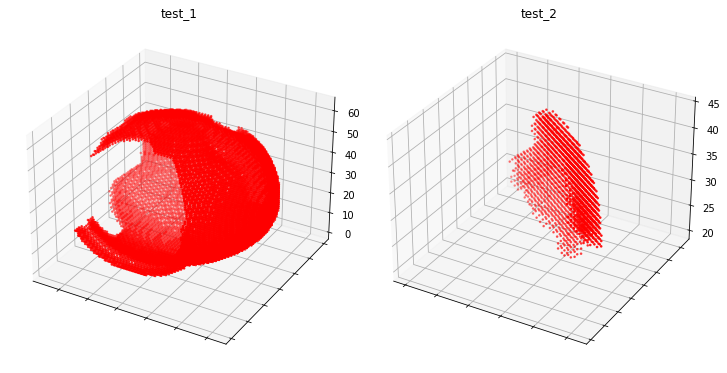

In [18]:
save_plot_voxels(mesh_frag.detach().cpu().numpy().reshape(-1, 1, 64, 64, 64), '', 0)

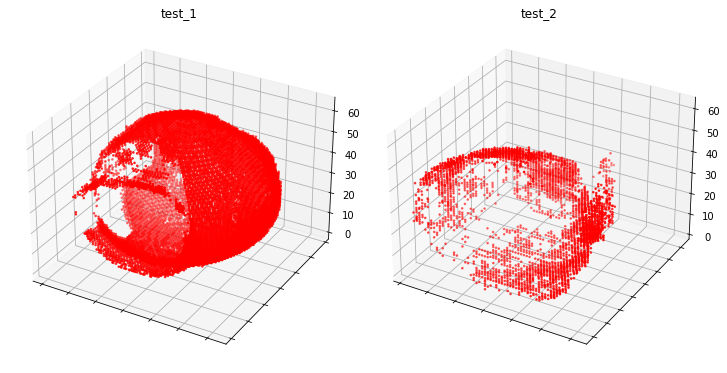

In [19]:
save_plot_voxels(fake.detach().cpu().numpy().reshape(-1, 1, 64, 64, 64), '', 0)

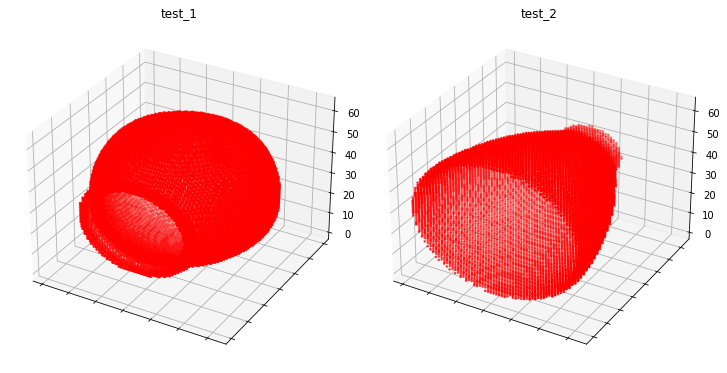

In [20]:
save_plot_voxels(mesh_complete.detach().cpu().numpy().reshape(-1, 1, 64, 64, 64), '', 0)